<a href="https://colab.research.google.com/github/shayar/ProblemSolvingwithDataScience/blob/AddingHealthInsuranceProject/HealthInsuranceCostPrediction/Python/HealthInsuranceCostPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Health Insurance Cost Prediction
This model aims to predict the cost of health insurance from patients with respect to their demographic region and medical data.

Dataset source link: [HealthInsuranceData](https://www.kaggle.com/datasets/mirichoi0218/insurance/data?select=insurance.csv)

## Step 1: Setting up important libraries

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score


## Step 2: Data Acquisition

In [32]:
h_df = pd.read_csv('insurance.csv')
h_df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


We fetched the data in h_df data frame then viewed the first 5 rows of data. Looking at the first 5 rows most of the data are numeric and some of the data are boolean catagorical data. Which we will encode in later steps.

## Step 3: Data Cleaning and Pre-preprocessing

We will start by checking for missing values.

In [33]:
h_df.isnull().sum()

,0
age,0
sex,0
bmi,0
children,0
smoker,0
region,0
charges,0


We don't have any missing values!

In [34]:
h_df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [35]:
df = h_df.copy()

Making a copy of the data before making changes to it.

In [36]:
df = pd.get_dummies(df, drop_first=True)

In [37]:
df

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,False,True,False,False,True
1,18,33.770,1,1725.55230,True,False,False,True,False
2,28,33.000,3,4449.46200,True,False,False,True,False
3,33,22.705,0,21984.47061,True,False,True,False,False
4,32,28.880,0,3866.85520,True,False,True,False,False
...,...,...,...,...,...,...,...,...,...
1333,50,30.970,3,10600.54830,True,False,True,False,False
1334,18,31.920,0,2205.98080,False,False,False,False,False
1335,18,36.850,0,1629.83350,False,False,False,True,False
1336,21,25.800,0,2007.94500,False,False,False,False,True


Using one hot encoding to convert categorical data into numerical data

## Checking and handling outliers

In [38]:
# 1. Select only numeric columns
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

# 2. Loop over each column
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]

    print(f"Column: {col}")
    print(f"Number of outliers: {outliers.shape[0]}")
    print("-" * 30)

Column: age
Number of outliers: 0
------------------------------
Column: bmi
Number of outliers: 9
------------------------------
Column: children
Number of outliers: 0
------------------------------
Column: charges
Number of outliers: 139
------------------------------


We found 9 outliers in bmi column and 139 outliers in charges column.
We did not check outliers for categorical encoded data as they only have boolean values.

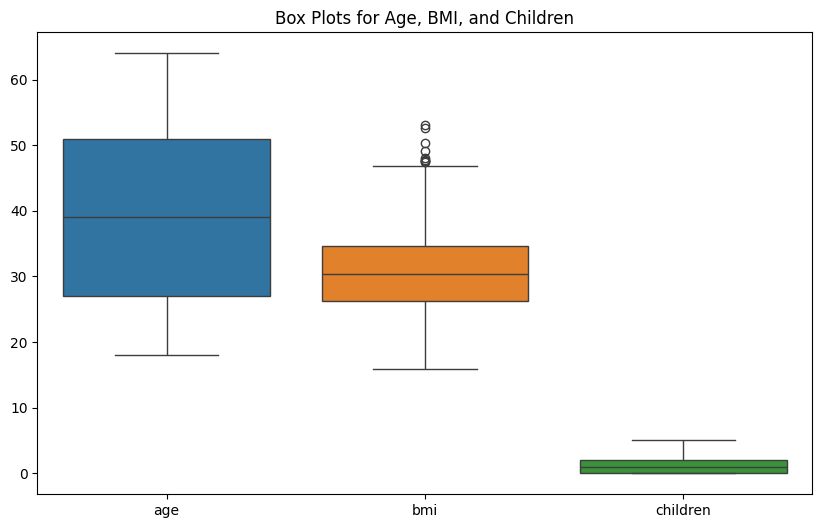

In [39]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[['age', 'bmi', 'children']])
plt.title('Box Plots for Age, BMI, and Children')
plt.show()


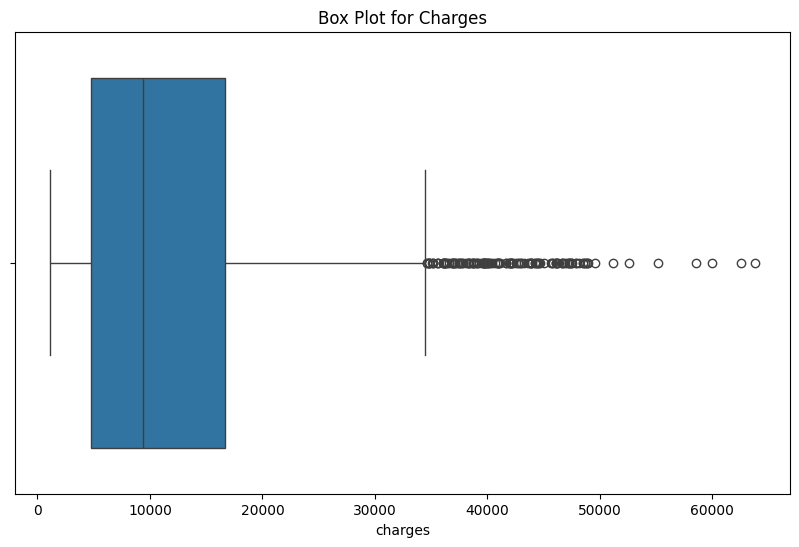

In [40]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['charges']) # Changed to create box plot of 'charges'
plt.title('Box Plot for Charges')
plt.show()


making separate box plots for these columns as charges has comparatively very high numerical margins(inter quartile range) that mess with our plot

### Handling outliers

In [41]:
# Calculating quartiles and IQR for the 'bmi' column
Q1_bmi = df['bmi'].quantile(0.25)
Q3_bmi = df['bmi'].quantile(0.75)
IQR_bmi = Q3_bmi - Q1_bmi

# Defining bounds for outlier detection
lower_bound_bmi = Q1_bmi - 1.5 * IQR_bmi
upper_bound_bmi = Q3_bmi + 1.5 * IQR_bmi

print(f"Original number of rows before filtering bmi outliers: {df.shape[0]}")

# Filtering out outliers in the 'bmi' column
df = df[(df['bmi'] >= lower_bound_bmi) & (df['bmi'] <= upper_bound_bmi)]

# Print the number of rows before and after outlier removal
print(f"Number of rows after removing 'bmi' outliers: {df.shape[0]}")


Original number of rows before filtering bmi outliers: 1338
Number of rows after removing 'bmi' outliers: 1329


As the number of outliers was not significant enough for bmi, we had 2 options to handle them i.e removing them or caping them inside the IQR. We opted to delete them.

But, Outliers in charge amounts to be 10% of our dataset so we will be using logorithm transformation to transform the data and check for outliers.

#### **Brief info about why we chose log transformation**

When data is skewed in large intervals like our highest charge in range might be around 1600 but the highest out of range charge is around 6500. We use log transform so the gap becomes much smaller!

Now you we draw graphs or do math without 10% outliers dominating the whole thing.

In [42]:
df['charges'] = np.log1p(df['charges'])

(The +1 safely handles if any charge = 0, although here it's probably not needed.)

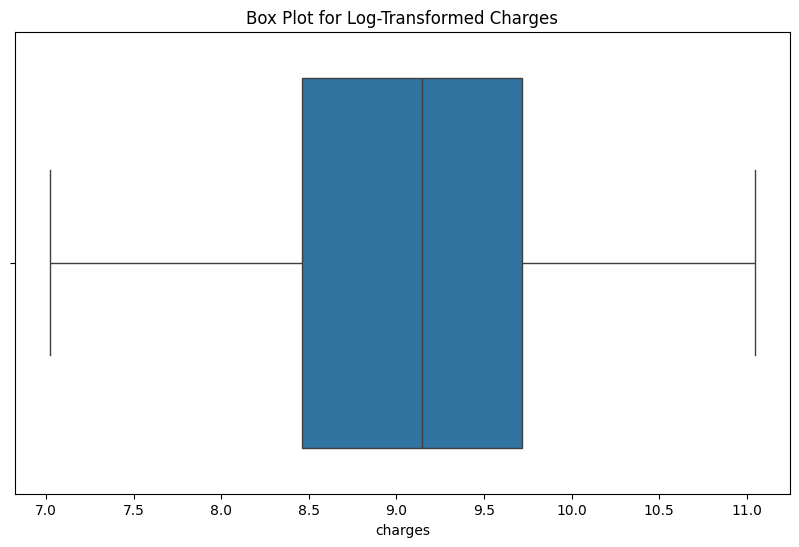

In [43]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=(df['charges']))
plt.title('Box Plot for Log-Transformed Charges')
plt.show()

We are done with pre-processing data.

## Step 4 Exploratory Data Analysis (EDA)


### Analysing distribution

Using a histogram we will be checking the spread of data and if they co-relate to each other.

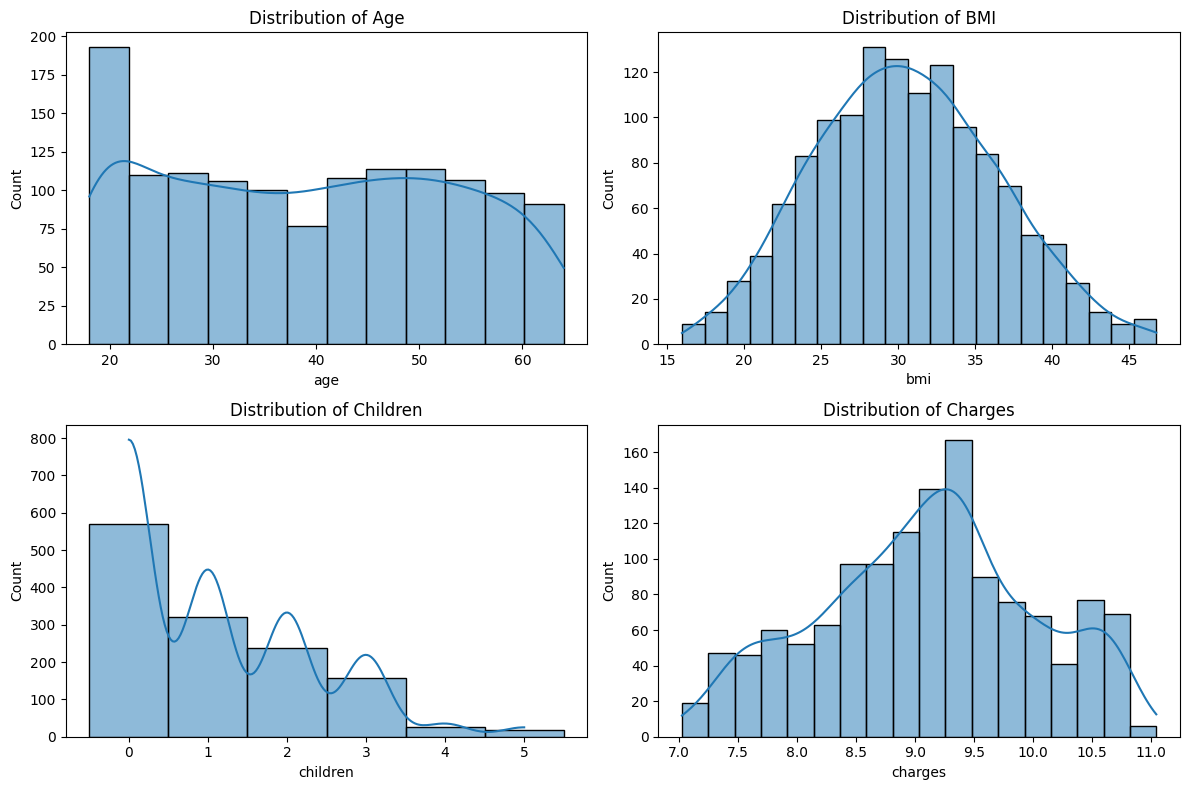

In [44]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
sns.histplot(df['age'], kde=True) # adds a smooth curve to show the overall distribution shape (Kernel Density Estimate)
plt.title('Distribution of Age')

plt.subplot(2, 2, 2)
sns.histplot(df['bmi'], kde=True)
plt.title('Distribution of BMI')

plt.subplot(2, 2, 3)
sns.histplot(df['children'], kde=True, discrete=True) # Use discrete=True for children
plt.title('Distribution of Children')

plt.subplot(2, 2, 4)
sns.histplot(df['charges'], kde=True)
plt.title('Distribution of Charges')

plt.tight_layout()
plt.show()


### What we got from the histogram



* The population is young and predominantly childless.
* Many individuals are overweight or obese.
* Age, BMI, and number of children likely influence insurance charges significantly.



### Heatmap and correlation

heatmap shows what features have strong positive or negative or no correlationship with each other (Especially with insurance charge).

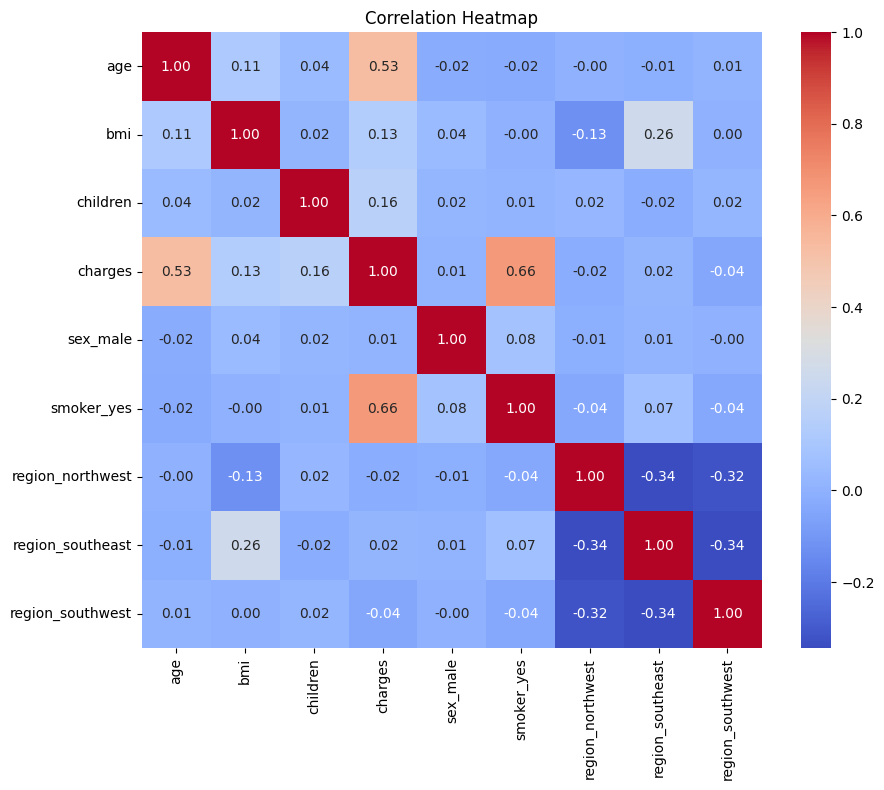

In [45]:
# Correlation matrix
corr_matrix = df.corr()

# Heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

### How Correlation is Actually Calculated?

We have used **Pearson Correlation Coefficient**

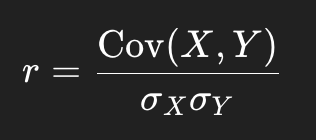

Where:

Cov(X,Y) = Covariance between X and Y (how they move together)

σ
X
  = Standard deviation of X

σ
Y
​
  = Standard deviation of Y


 **In Simple Words**:

* Covariance measures if X and Y move together (positive) or opposite (negative).

* Standard deviation measures how spread out X and Y are individually.

* Pearson correlation divides the covariance by the standard deviations ➔ gives a pure scale-free number between -1 and +1.

### EDA Finding on Correlation Heatmap for Insurance Charges Prediction:

* Smoking status shows the strongest positive correlation (+0.66) with medical charges, indicating smokers are charged significantly higher.

* Age has a moderate positive correlation (+0.53) with charges — older individuals typically have higher costs.

* BMI and number of children have weak correlations with charges (~+0.13 and +0.16 respectively), suggesting minor effects.

* Gender and Region features have near-zero correlation with charges, indicating they may not contribute significantly to prediction.

Recommendation for Modeling: Focusing heavily on smoking status, age, and possibly BMI as key predictors.

In [46]:
# Creating interaction feature: Age × Smoker
df['age_smoker'] = df['age'] * df['smoker_yes']

# Creating interaction feature: BMI × Smoker
df['bmi_smoker'] = df['bmi'] * df['smoker_yes']

df.head()

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest,age_smoker,bmi_smoker
0,19,27.900,0,9.734236,False,True,False,False,True,19,27.9
1,18,33.770,1,7.453882,True,False,False,True,False,0,0.0
2,28,33.000,3,8.400763,True,False,False,True,False,0,0.0
3,33,22.705,0,9.998137,True,False,True,False,False,0,0.0
4,32,28.880,0,8.260455,True,False,True,False,False,0,0.0


We tried to add feature interaction. Because interaction features capture this "combined effect" that plain features miss.

Example:

Age might not fully explain medical charges.
Smoking status might not fully explain charges either.
But Older Smokers could have crazy high charges — much more than you'd guess by looking at just age or just smoker separately.

### Visualizing using plots

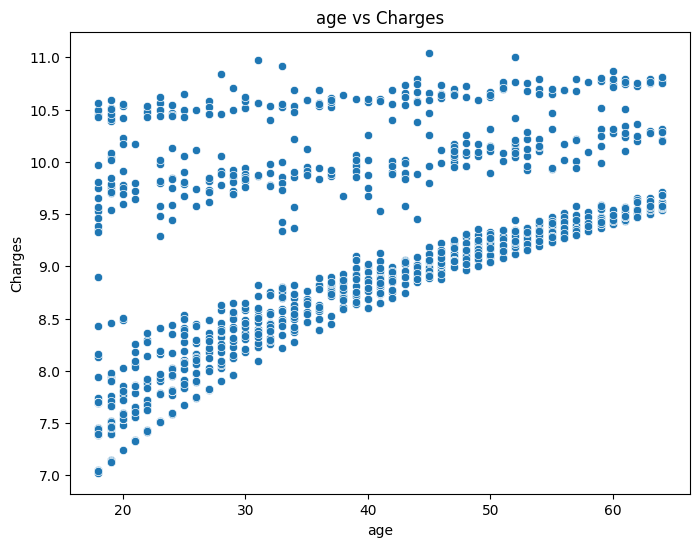

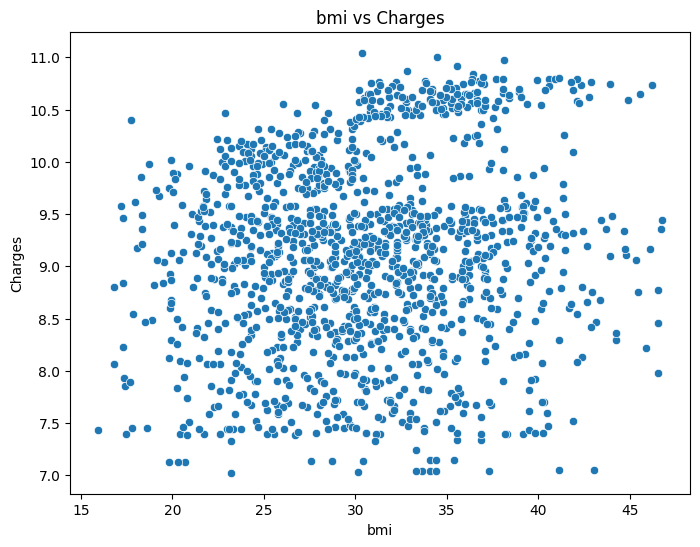

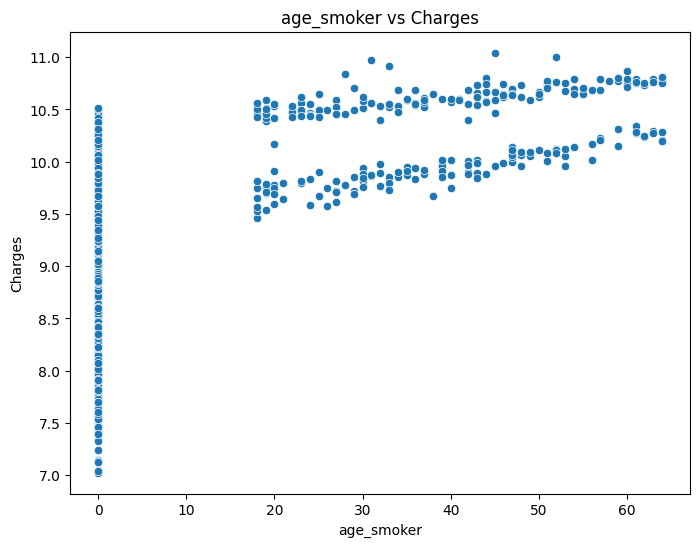

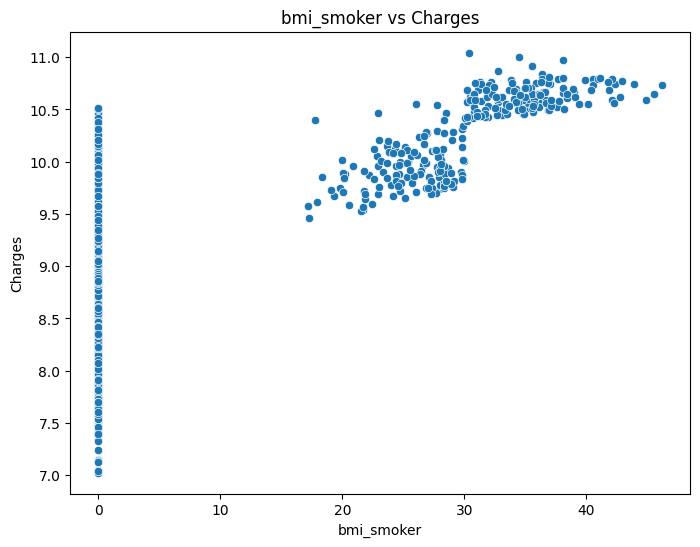

In [47]:
features = ['age', 'bmi', 'age_smoker', 'bmi_smoker']

for feature in features:
    plt.figure(figsize=(8,6))
    sns.scatterplot(x=feature, y='charges', data=df)
    plt.title(f'{feature} vs Charges')
    plt.xlabel(feature)
    plt.ylabel('Charges')
    plt.show()

### Findings

**Main Findings**:

age vs charges ➔ As age increases, charges tend to rise, but the relationship is mixed because smoking is not accounted for.

bmi vs charges ➔ No clear trend; BMI alone is a weak predictor of charges.

age_smoker vs charges ➔ Strong upward trend among smokers: older smokers have much higher charges.

bmi_smoker vs charges ➔ Clear positive trend: smokers with higher BMI are charged more.

**Insights**:

Interaction features (age_smoker, bmi_smoker) reveal hidden patterns that were not visible from age and bmi alone.

These engineered features have made our model smarter and more accurate by capturing important real-world behavior (smokers get charged more, especially if they are older or heavier).

### Concluding EDA

Looking at the correlation coefficient and heatmaps along with different plots. We have realized that features alone like age and bmi could not reflect, what these features along with smoking reveal.

After EDA we have come to conclude that Smoking is one of the key factors for a persons high health insurance cost.

## Step 5: Model Training

### Spliting the Data into Training and Testing Sets

By training the model on one part of the data then testing it on unseen data to see how well it generalizes.

In [48]:
# Selecting features and target
features = ['age', 'bmi', 'children', 'smoker_yes', 'age_smoker', 'bmi_smoker'] # we have ignored region as it didn't impact the insurance charge
target = 'charges'  # Log-transformed charges

X = df[features]
y = df[target]

# Spliting into 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # random_state = 42 to maintain consistancy

### Training a Linear Regression Model

Why Linear Regression?

Simple, interpretable, and a good baseline model.

In [49]:
# Initializing the model
lr_model = LinearRegression()

# Training (fit) the model
lr_model.fit(X_train, y_train)

LinearRegression()

Now, that the model is trained, let's see how well it performs

### Evaluating the Model

* MSE (Mean Squared Error)

  * Tells us how far off our model’s predictions are from the real answers — but it squares the difference to make big mistakes count more.

  * Imagine you guessed everyone’s height, and then checked how far off you were for each person. MSE says: “How bad were your guesses, on average?”

  * Good when: Small number (closer to 0)

* RMSE (Root Mean Squared Error)

  * Just the square root of MSE.

  * gives the error in the same units as your target (like dollars if you're predicting money). That makes it easier to understand.

  * If MSE is like “how bad were your guesses squared?”, then RMSE is like “how bad were they in real-life terms.”

  * Good when: Small

* R² Score (R-squared)

  * tells us how much of the variation in the data the model can explain.

  * Between 0 and 1:

    0 → model is useless

    1 → model is perfect

    0.8 → model explains 80% of the behavior

  * If you were guessing grades based on study hours, R² tells you how much your guesses are actually based on the study time — or if you're just guessing randomly.

In [50]:
# Predicting on test set
y_pred = lr_model.predict(X_test)

# Evaluating
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

Mean Squared Error (MSE): 0.1583
Root Mean Squared Error (RMSE): 0.3979
R² Score: 0.7990


Real Meaning

R² = 0.799	Capturing most of the cost behavior — like how smoking, age, and BMI affect charges.

RMSE ≈ 0.4 (log scale)	Our predictions are about 48% off, on average, in real dollar terms.

MSE = 0.1583	Just a squared version of error — useful for optimization, less intuitive.

### Summary

* It explains almost 80% of the variance in costs.
* It uses meaningful features (age, smoking, BMI).
* It handles skew in data using log transformation.
* Our RMSE is reasonable, considering the dataset has large charge variations.

### Cross-Validation

Why?

Helps see if our trained model is performing as seen or is being lucky by making 5 folds of independent scenarios.

In [51]:
# Doing 5-fold cross-validation on training data
scores = cross_val_score(lr_model, X, y, cv=5, scoring='neg_mean_squared_error')

# Getting average RMSE across folds
rmse_scores = np.sqrt(-scores)
print("Cross-Validated RMSE:", rmse_scores.mean())

Cross-Validated RMSE: 0.3893950414592251


Our new RMSE score tured out to be almost equal, meaning that our model is performing as intended in all 5 folds.

## Step 6: Model Interpretation

In [52]:
# Get feature names and coefficients
coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lr_model.coef_
})

# Sort by absolute value of coefficient
coef_df['abs_coef'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='abs_coef', ascending=False)

# Drop helper column if you want
coef_df = coef_df[['Feature', 'Coefficient']]

print(coef_df)


      Feature  Coefficient
3  smoker_yes     1.295370
2    children     0.114801
5  bmi_smoker     0.052441
0         age     0.042270
4  age_smoker    -0.034679
1         bmi    -0.001348


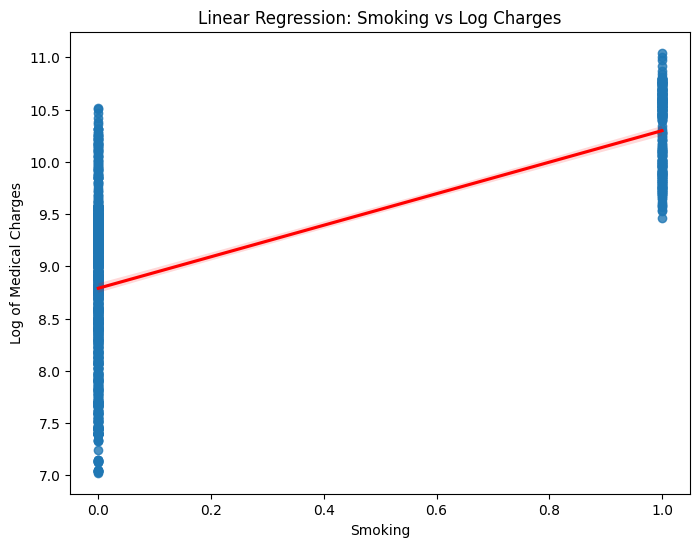

In [54]:
# Ploting smoking vs log(charges) with regression line
plt.figure(figsize=(8,6))
sns.regplot(x='smoker_yes', y='charges', data=df, line_kws={"color":"red"})
plt.title('Linear Regression: Smoking vs Log Charges')
plt.xlabel('Smoking')
plt.ylabel('Log of Medical Charges')
plt.show()

## Conclusion

* Biggest driver of medical charges = Smoking.
* Age matters (older = more expensive).
* BMI only matters when combined with smoking.
* Children have a small effect.
* Sex and Region were not important.
* If a person is a smoker, the predicted log-medical charges increase by about 1.295 units.